## Telco

## Function Stuff

#### Pull Data Function (CSV or SQL with personal env file)

In [1]:
import os
import pandas as pd
from env import db_url
import time
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
pd.set_option('display.max_colwidth', 200)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_telco_data():
    """
    This function retrieves the telco data from a CSV file if it exists,
    otherwise it retrieves the data from a SQL database and saves it to a CSV file.
    This function assumes the user has an env file formatted as:
    __________________________________________________
    user = "username"
    password = "password"
    host = "host"

    f"mysql+pymysql://{user}:{password}@{host}/{db}"
    __________________________________________________
    
    Args:
    - None

    Returns:
    - df: pandas dataframe containing the telco data
    """
    filename = "telco.csv"
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        query = """
        SELECT *
        FROM customers
        JOIN contract_types
        ON customers.contract_type_id = contract_types.contract_type_id
        JOIN internet_service_types
        ON customers.internet_service_type_id = internet_service_types.internet_service_type_id
        JOIN payment_types
        ON customers.payment_type_id = payment_types.payment_type_id;"""
        connection = db_url("telco_churn")
        df = pd.read_sql(query, connection)
        df.to_csv(filename, index=False)
    return df

#### Clean Function with Binary KWA (default=False)

In [2]:
import pandas as pd
import numpy as np

def prep_telco(df, binary=False):
    # Drop the joiner columns from SQL and definitely useless columns
    df = df.drop(
        columns=[
            "internet_service_type_id",
            "contract_type_id",
            "payment_type_id",
            "contract_type_id.1",
            "internet_service_type_id.1",
            "payment_type_id.1",
        ]
    )
    # Fill NA in internet service type with what the rest of the table uses, 'No internet service'.
    df["internet_service_type"].fillna("No internet service", inplace=True)
    
    # As we've noticed before, ['total_charges'] is detected as an object, but holds mainly numbers. We'll use pd.to_numeric() to force everything to a number,
    # and anything that it cannot convert, we'll make it Null and investigate those.
    df["total_charges"] = pd.to_numeric(
        df["total_charges"], errors="coerce"
    )
    # Total charges = 0 also has Tenure = 0. We'll assume they're new and haven't been charged
    df["total_charges"].fillna(0, inplace=True)

    # Automatic payments could be important for churn, so we will separate it from the payment method
    df["automatic_payments"] = (
        df["payment_type"] == "Bank transfer (automatic)"
    ) | (df["payment_type"] == "Credit card (automatic)")

    # Now that it is separated, we remove 'automatic_payment' from the payment types. Made casing uniform
    df["payment_type"].replace(
        {
            "Electronic check": "electronic check",
            "Mailed check": "mailed check",
            "Credit card (automatic)": "credit card",
            "Bank transfer (automatic)": "bank transfer",
        },
        inplace=True,
    )

    # Change senior_citizen to Yes/No for better visuals
    df["senior_citizen"].replace({0: "No", 1: "Yes"}, inplace=True)

    # Bin the tenure into groups of 12 to separate by year
    df["tenure_years"] = df["tenure"].apply(
        lambda x: int((x - 1) / 12)
    )
    
    # Change from True / False to Yes / No for visuals and uniformity, also for tablewide binary conversion later
    df["automatic_payments"].replace({False: "No", True: "Yes"}, inplace=True)

    # Create a total add ons that counts all of the add ons
    df["total_add_ons"] = df[
        [
            "phone_service",
            "online_security",
            "online_backup",
            "device_protection",
            "tech_support",
            "streaming_tv",
            "streaming_movies",
        ]
    ].apply(lambda x: (x == "Yes").sum(), axis=1)
    
    # Due to needing the customer_id later, we can't drop it. We'll assign it as
    # the index to keep it out of the way
    df.set_index('customer_id', inplace=True)
    
    # Rename some columns 
    df.rename(columns={'tenure': 'tenure_months',
                             'partner': 'married',
                             'dependents': 'kids',
                             }, inplace=True)

    if binary == False:
        return df
    else:
        df = telco_binary_normalized(df)
        return df

#### Good Information Collection Function for Dataframe

In [3]:
import pandas as pd

def check_columns(df):
    """
    This function takes a pandas dataframe as input and prints
    out information about each column in the dataframe. For 
    each column, it prints the column name, the number of
    unique values in the column, the unique values themselves,
    and the number of null values in the column.

    Args:
    - df: pandas dataframe

    Returns:
    - None
    """
    for column in df.columns:
        print(f"{column} ({df[column].nunique()})")
        print(f"Unique Values: {df[column].unique()}")
        print(f"Null Values: {df[column].isna().sum()}")
        print("")

#### Telco Binary Function

In [4]:
def telco_binary(df_telco):
    """
    This function takes in a pandas dataframe and returns
    a modified version of the dataframe with binary values
    for certain columns.

    Args:
    - df_telco: pandas dataframe

    Returns:
    - df_telco: pandas dataframe
    """
    # Replace values with binary values
    df_telco.replace({
        'No internet service': 0,
        'No phone service': 0,
        'No': 0,
        'Yes': 1,
        'Male': 1, 
        'Female': 0}, inplace=True)
    
    # 3 Categories (but we want to keep all 3)
    categorical = ['contract_type', 'payment_type', 'internet_service_type']

    # Get dummies for categorical columns
    cat = pd.get_dummies(df_telco[categorical], drop_first=False, dtype='int')

    # Drop redundant columns
    cat.drop(columns='internet_service_type_0', inplace=True)

    # Rename columns for uniformity
    cat.rename(columns={'contract_type_Month-to-month':'month_to_month_contract',
            'contract_type_One year':'one_year_contract',
            'contract_type_Two year':'two_year_contact',
            'payment_type_bank transfer':'bank_transfer_payment',
            'payment_type_credit card':'credit_card_payment', 
            'payment_type_electronic check':'e_check_payment',
            'payment_type_mailed check':'mailed_check_payment',
            'internet_service_type_DSL':'dsl_internet',
            'internet_service_type_Fiber optic':'fiber_optic_internet'}
        , inplace=True)

    # Concatenate the original dataframe with the categorical dataframe
    df_telco = pd.concat([df_telco, cat], axis=1)
    return df_telco

## Surface Level Exploration - Explain our prep function

## Prepping Telco

In [5]:
# Get the data (CSV or pull from SQL with personal env file)

df_telco_full = get_telco_data()

In [6]:
# Clean the dataframe, optionally use binary=True to output the binary version. (Default is False)

# Use non-binary for better visualization
df_telco = prep_telco(df_telco_full)

## Split Data

In [7]:
from sklearn.model_selection import train_test_split

def split_telco(df):
    """
    take in a DataFrame and return train, validate, and test DataFrames; stratify on a specified variable.
    return train, validate, test DataFrames.
    """
    train_validate, test = train_test_split(
        df, test_size=0.2, random_state=123, stratify=df['churn']
    )
    train, validate = train_test_split(
        train_validate, test_size=0.3, random_state=123, stratify=train_validate['churn']
    )
    print(f"train: {len(train)} ({round(len(train)/len(df), 2)*100}% of {len(df)})")
    print(f"validate: {len(validate)} ({round(len(validate)/len(df), 2)*100}% of {len(df)})")
    print(f"test: {len(test)} ({round(len(test)/len(df), 2)*100}% of {len(df)})")
    
    return train, validate, test

## Train, Validate, Test

In [8]:
train, validate, test = split_telco(df_telco)

train: 3943 (56.00000000000001% of 7043)
validate: 1691 (24.0% of 7043)
test: 1409 (20.0% of 7043)


In [9]:
# describe train data
train.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure_months,3943.0,32.473244,24.551176,0.00,9.000,29.00,55.00,72.00
monthly_charges,3943.0,65.328937,30.261023,18.25,35.900,70.55,90.25,118.75
total_charges,3943.0,2310.297451,2282.121687,0.00,413.125,1404.65,3910.00,8672.45
tenure_years,3943.0,2.186153,1.935369,0.00,0.000,2.00,4.00,5.00
total_add_ons,3943.0,2.990616,1.863605,0.00,1.000,3.00,4.00,7.00


## Visual Exploration

<b> All of the visuals we use will be normalized. We'll normalize due to the dataset being imbalanced. </b>

<i>This is achieved by dividing the count of each value of the response variable by the total number of observations. The resulting values represent the proportion of observations that have each value of the response variable, and sum to 1. AKA proportions.

`sklearn`'s `mutual_info_score` is a function that computes the mutual information between two random variables. Mutual information is a measure of the amount of information that one random variable contains about another random variable. It is defined as the reduction in uncertainty about one variable given knowledge of the other variable.

In the context of machine learning, mutual information is often used as a feature selection method. It can be used to measure the dependence between a feature and the target variable, and can help identify features that are most relevant for predicting the target variable.

The `mutual_info_score` function takes two arrays as input, representing the two random variables, and returns the mutual information between them. The function can be used with both discrete and continuous variables, and can handle multiclass classification problems.

Note that mutual information is a symmetric measure, meaning that the mutual information between variable A and variable B is the same as the mutual information between variable B and variable A.

The mutual information extends the notion of correlation to nonlinear relationships since, unlike Pearson’s correlation coefficient, this method is able to detect not only linear relationships but also nonlinear ones.

- The Scikit-Learn library has implemented mutual information in the metrics package.

The mutual information score is a measure of the mutual dependence between two variables. It measures the amount of information that can be obtained about one variable by observing the other variable. 

In the context of feature selection, the mutual information score can be used to identify the categorical variables that are most strongly associated with the response variable (churn). The mutual information score is sensitive to both linear and non-linear relationships between the variables. This means that it can capture non-linear relationships between the categorical variables and the response variable, which may not be captured by other measures of association, such as correlation coefficients.

Therefore, the mutual information score is a useful measure for identifying important categorical variables that may have non-linear relationships with the response variable.

Mutual information — analysis of linear and nonlinear relationships

Mutual information measures the mutual dependency between two variables based on entropy estimations. In machine learning, we are interested in evaluating the degree of dependency between each independent variable and the response variable. Higher values of mutual information show a higher degree of dependency which indicates that the independent variable will be useful for predicting the target.

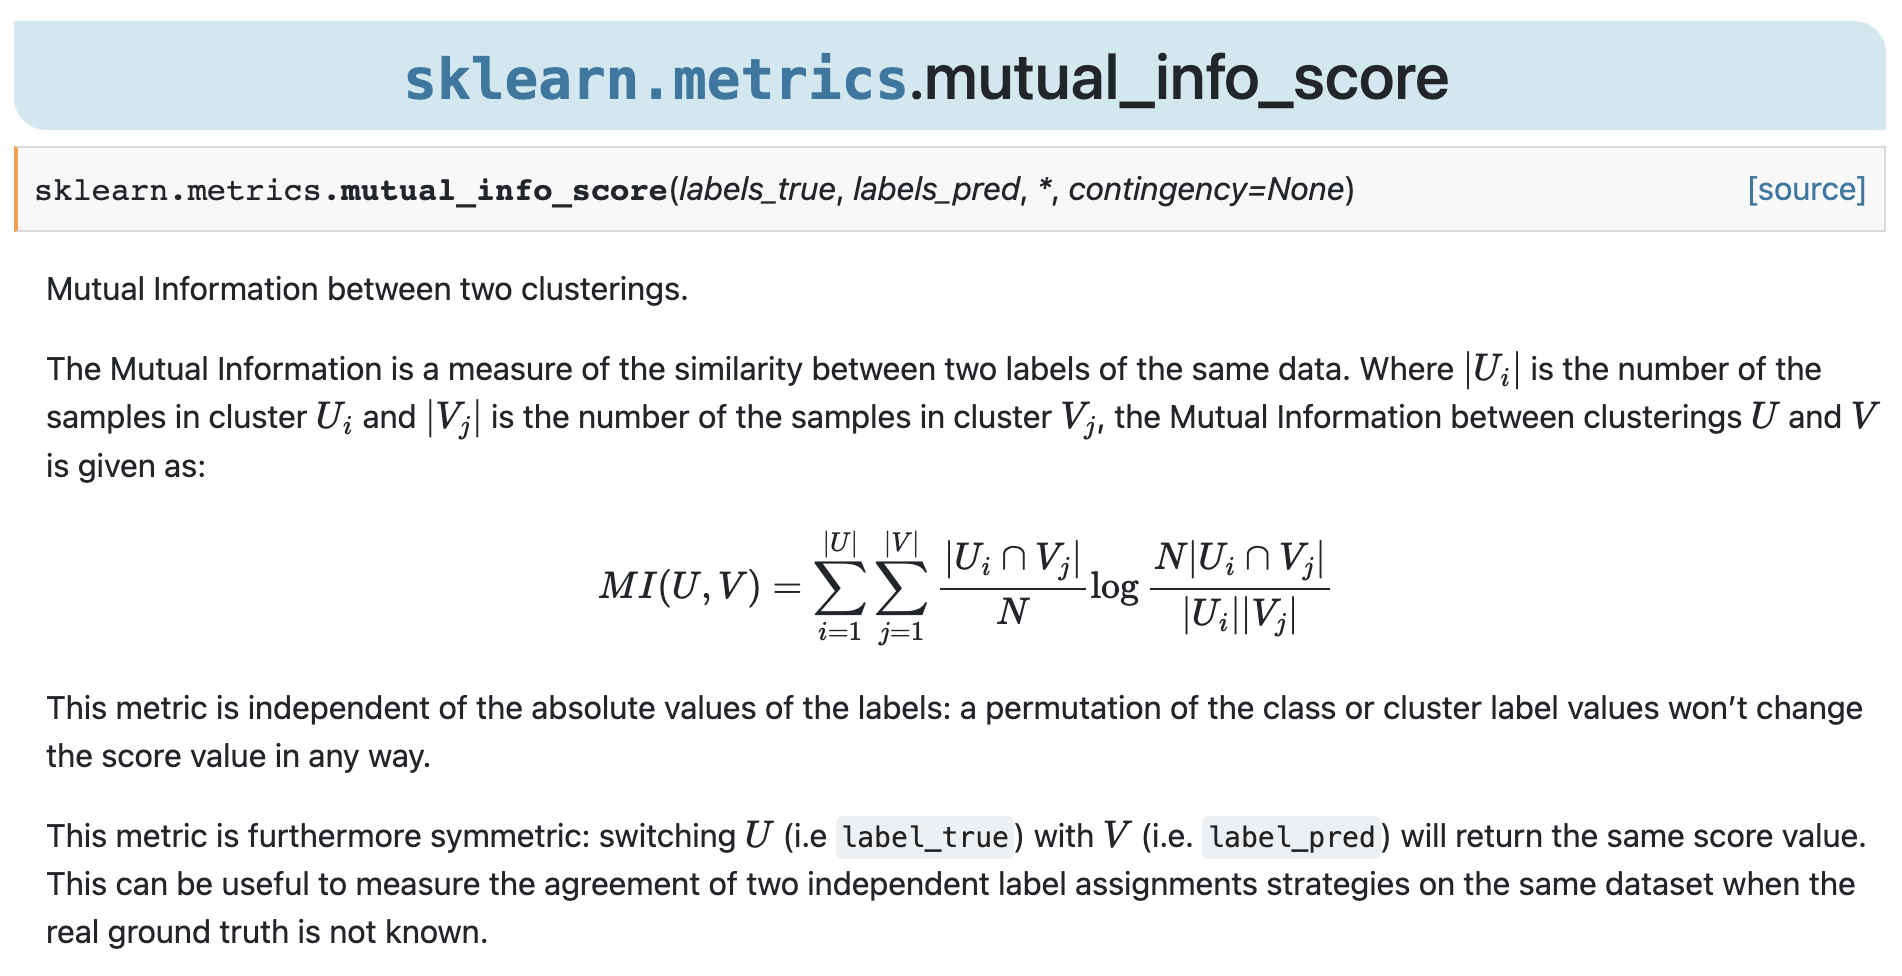

In [10]:
# The following code computes the mutual information score between each categorical 
# variable of the data set and the Churn variable.

from sklearn.metrics import mutual_info_score

def compute_mutual_information(categorical_series):
    return mutual_info_score(categorical_series, train['churn'])

# select categorial variables excluding the response variable 
categorical_variables = train.select_dtypes(include=object).drop('churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

contract_type            9.466954e-02
online_security          5.931822e-02
tech_support             5.730368e-02
internet_service_type    5.369545e-02
online_backup            4.617674e-02
payment_type             4.362608e-02
device_protection        4.270395e-02
streaming_tv             3.035270e-02
streaming_movies         3.031502e-02
automatic_payments       2.459980e-02
paperless_billing        1.848869e-02
kids                     1.508075e-02
married                  1.274710e-02
senior_citizen           8.890248e-03
multiple_lines           5.574319e-04
phone_service            4.622386e-05
gender                   2.240592e-07
dtype: float64


- Gender, phone_service, and multiple_lines have a mutual information score really close to 0, meaning those variables do not have a strong relationship with the target. 

- This information is in line with the conclusions we have previously drawn by visualizing the data. In the following steps, we should consider removing those variables from the data set before training as they do not provide useful information for predicting the outcome.

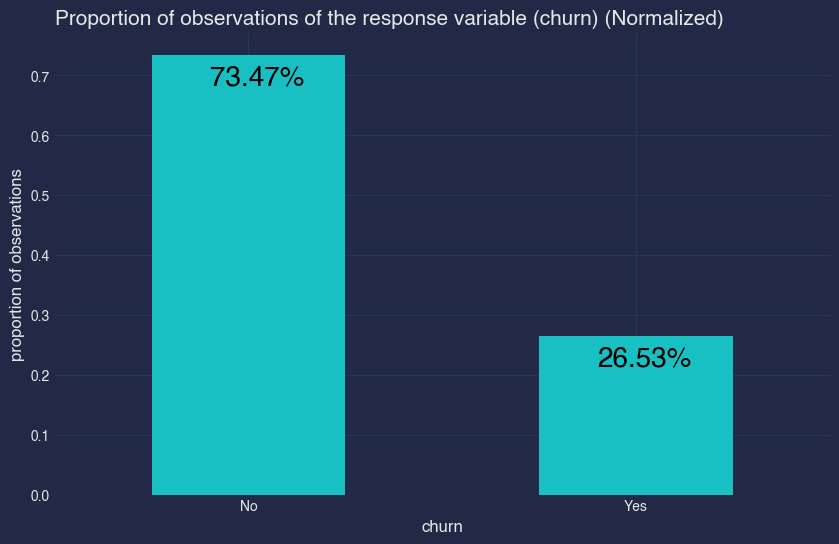

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# create a figure
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111)

# proportion of churn
prop_response = train['churn'].value_counts(normalize=True)

# bar plot showing the percentage of churn
prop_response.plot(kind='bar', 
                   ax=ax)

# add value counts to the top of each bar
for i, v in enumerate(prop_response):
    ax.text(i - 0.1, v - 0.05, str(round(v*100, 2)) + '%', fontsize=20, color='black')

# set labels and titles
ax.set_title('Proportion of observations of the response variable (churn) (Normalized)',
             fontsize=15, loc='left')
ax.set_xlabel('churn',
              fontsize=12)
ax.set_ylabel('proportion of observations',
              fontsize=12)
ax.tick_params(rotation='auto')


- This is an imbalanced data set.

- Both classes are not equally distributed among all observations, being 'No' the majority class (73.46%).

- When modeling, this imbalance will most likely lead to a large number of false negatives.

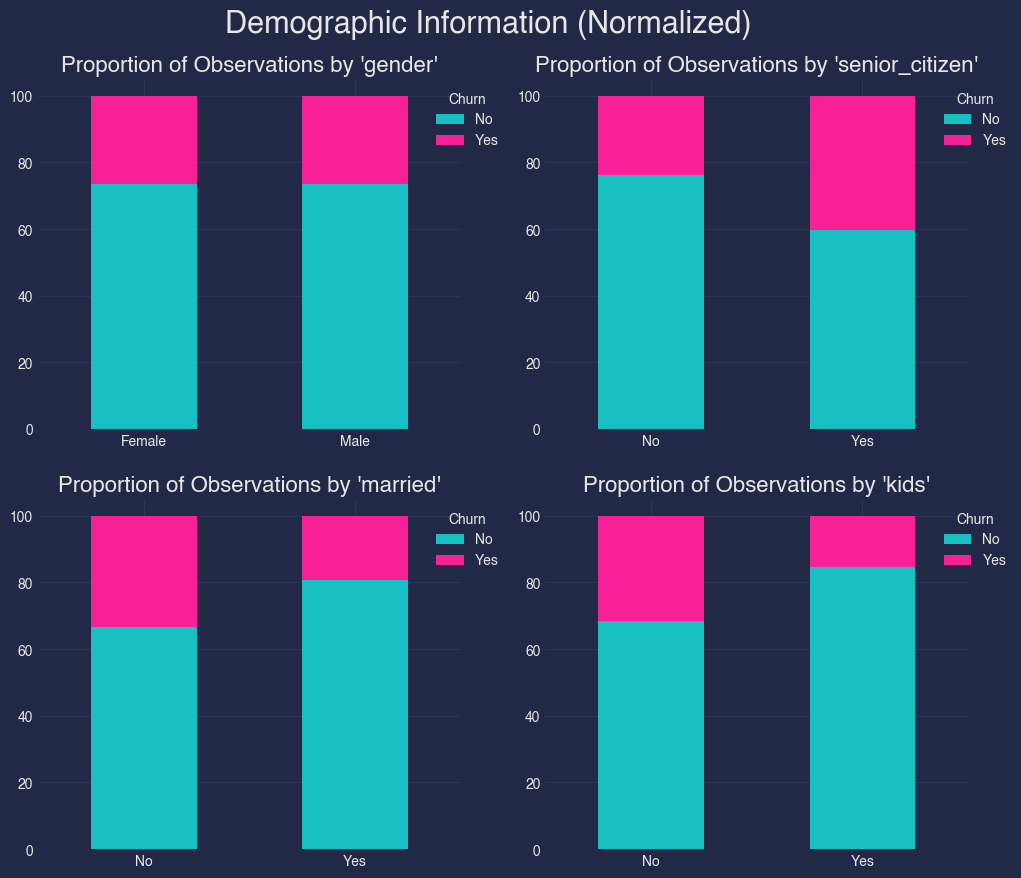

In [12]:
import math

def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(train[column], train['churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0)

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title(f"Proportion of Observations by '{column}'",
                     fontsize=16, loc='center')

        ax.tick_params(rotation='auto')
        ax.set_xlabel('')

# demographic column names
demographic_columns = ['gender', 'senior_citizen', 'married', 'kids']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Demographic Information (Normalized)')

- The churn rate of senior citizens is almost double that of young citizens.

- We do not expect gender to have significant predictive power. A similar percentage of churn is shown both when a customer is a man or a woman.

- Customers with a partner churn less than customers with no partner.

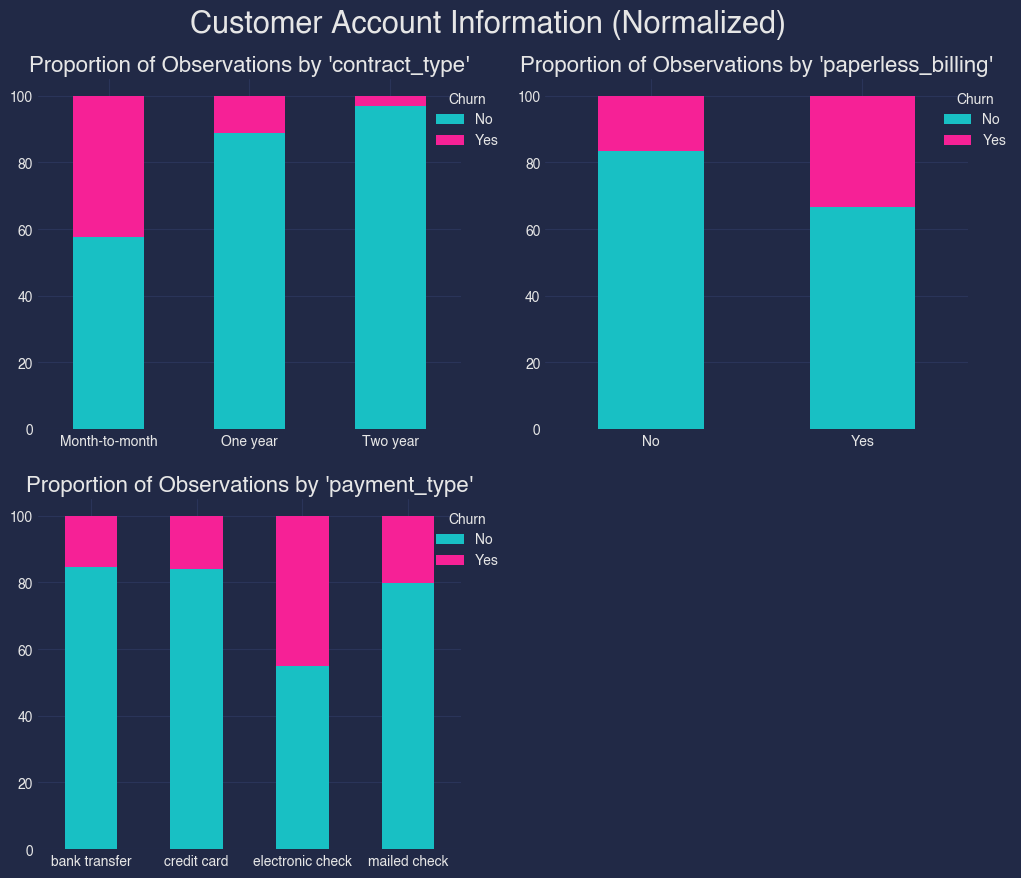

In [13]:
# Account Information
account_columns = ['contract_type', 'paperless_billing', 'payment_type']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Customer Account Information (Normalized)')

- Customers with month-to-month contracts have higher churn rates compared to clients with yearly contracts.

- Customers who opted for an electronic check as paying method are more likely to leave the company.

- Customers subscribed to paperless billing churn more than those who are not subscribed.

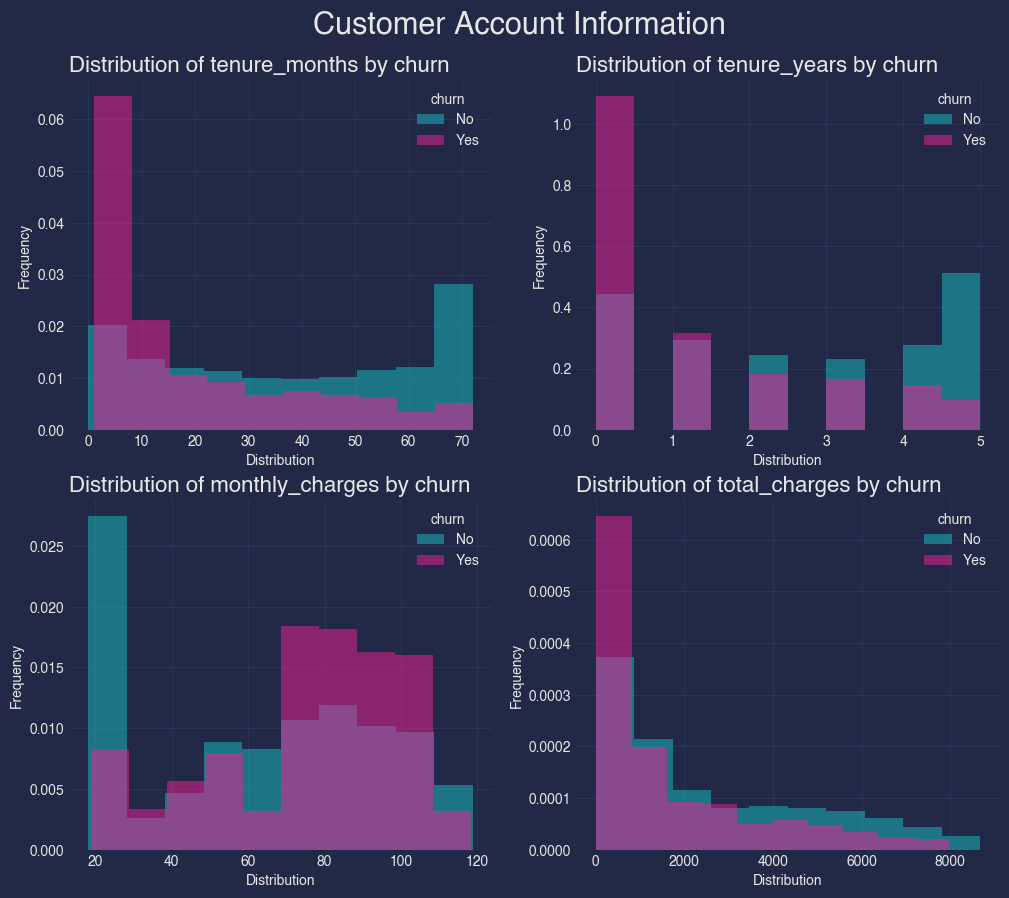

In [14]:
def histogram_plots(columns_to_plot, title):
    # set number of rows and number of columns
    column_number = 2
    row_number = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * row_number)) 
    fig.suptitle(title, fontsize=22,  y=.95)


    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(row_number, column_number, index)

        # histograms for each class (normalized histogram)
        train[train['churn']=='No'][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, label='No')
        train[train['churn']=='Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, label='Yes')
        
        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='churn', fancybox=True)

        # set title and labels
        ax.set_title('Distribution of ' + column + ' by churn',
                     fontsize=16, loc='left')
        ax.set_xlabel('Distribution')

        ax.tick_params(rotation='auto')
        
# customer account column names
account_columns_numeric = ['tenure_months','tenure_years', 'monthly_charges', 'total_charges']

# histogram of costumer account columns
histogram_plots(account_columns_numeric, 'Customer Account Information')

- The churn rate tends to be larger when monthly charges are high.

- New customers (low tenure) are more likely to churn.

- Clients with high total charges are less likely to leave the company.

- If they stay at least 3 years, they're more likely to not churn

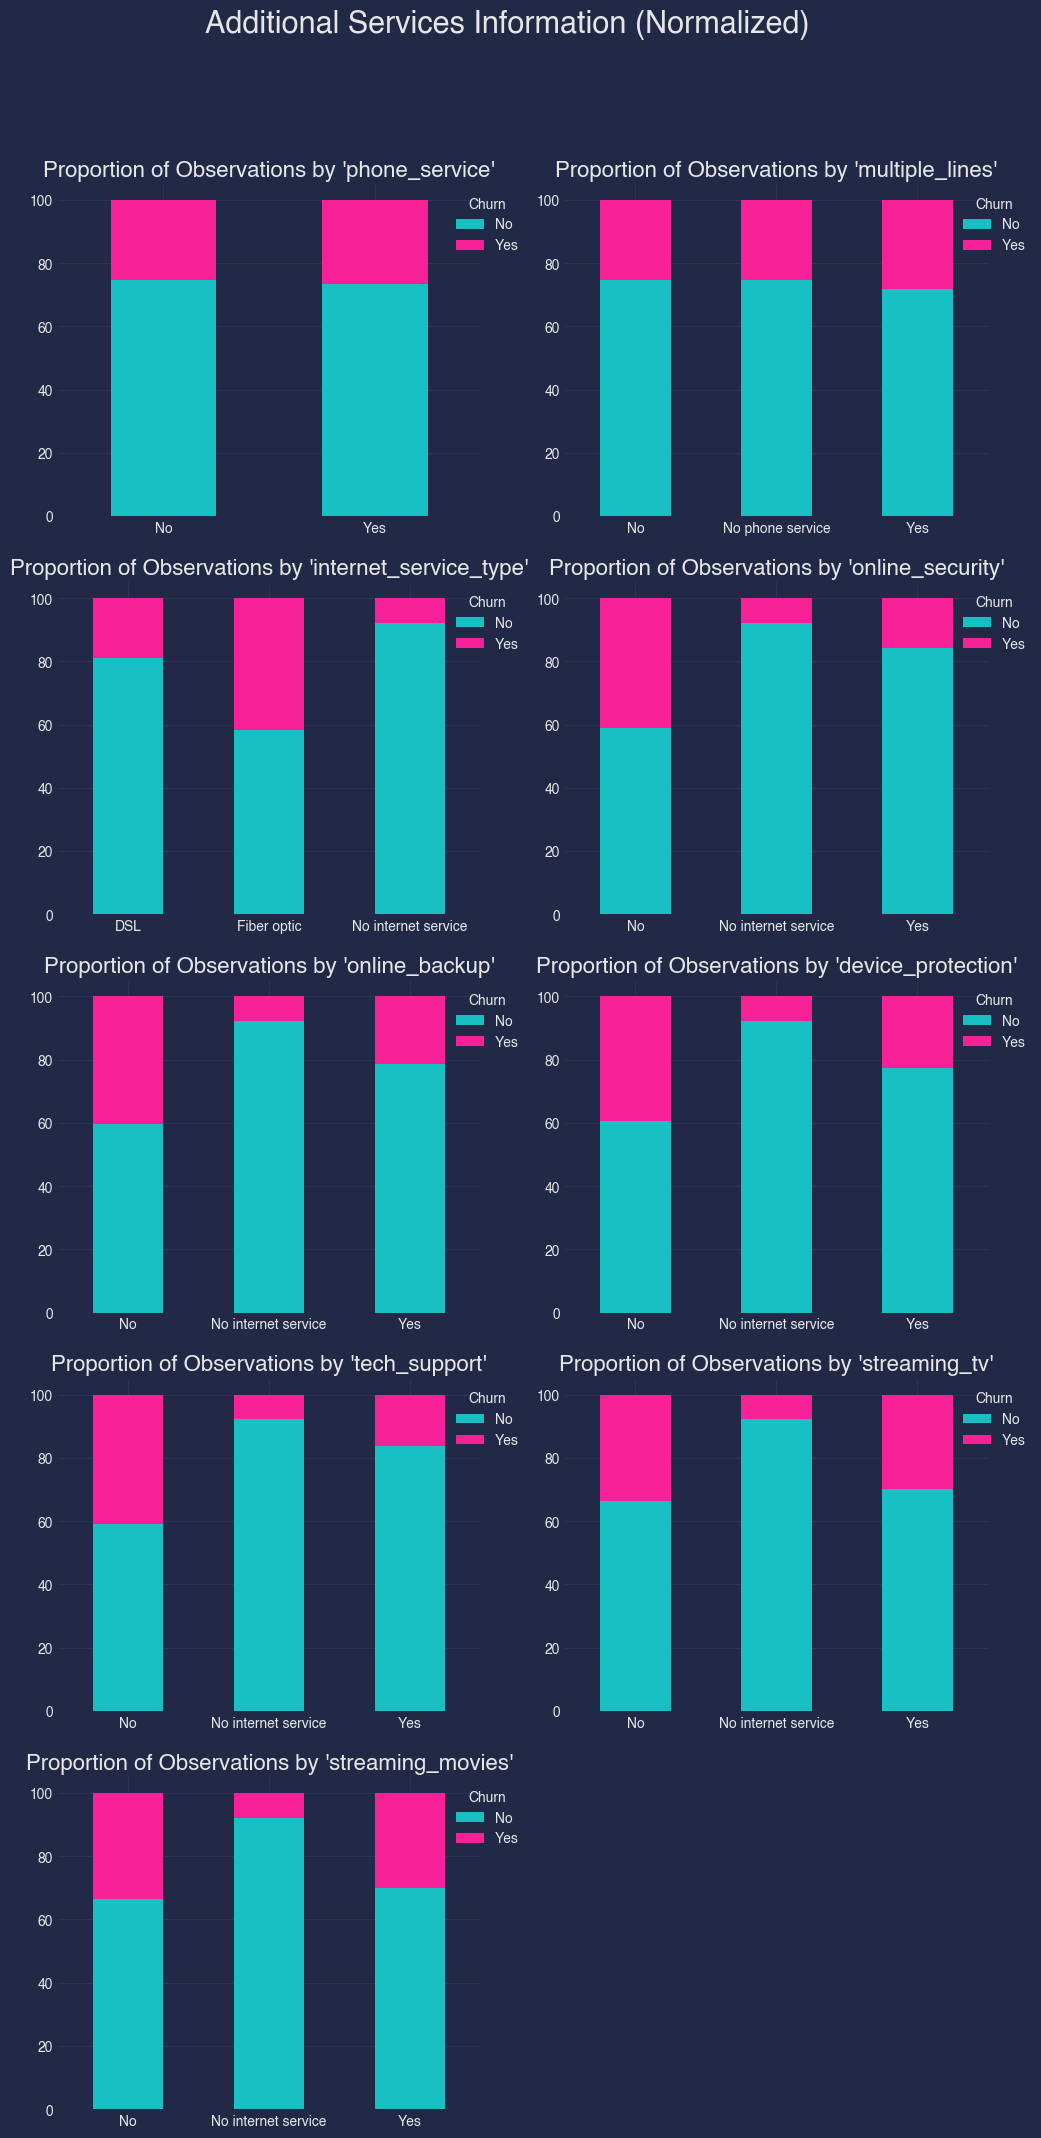

In [15]:
# services column names
services_columns = ['phone_service', 'multiple_lines', 'internet_service_type', 'online_security',
                   'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Additional Services Information (Normalized)')

- We do not expect phone attributes (PhoneService and MultipleLines) to have significant predictive power. The percentage of churn for all classes in both independent variables is nearly the same.

- Clients with online security churn less than those without it.

- Customers with no tech support tend to churn more often than those with tech support.

contract_type            0.098453
online_security          0.064677
tech_support             0.063021
internet_service_type    0.055574
online_backup            0.046792
payment_type             0.044519
device_protection        0.043917
streaming_movies         0.032001
streaming_tv             0.031908
automatic_payments       0.022886
paperless_billing        0.019194
kids                     0.014467
married                  0.011454
senior_citizen           0.010577
multiple_lines           0.000801
phone_service            0.000072
gender                   0.000037
dtype: float64


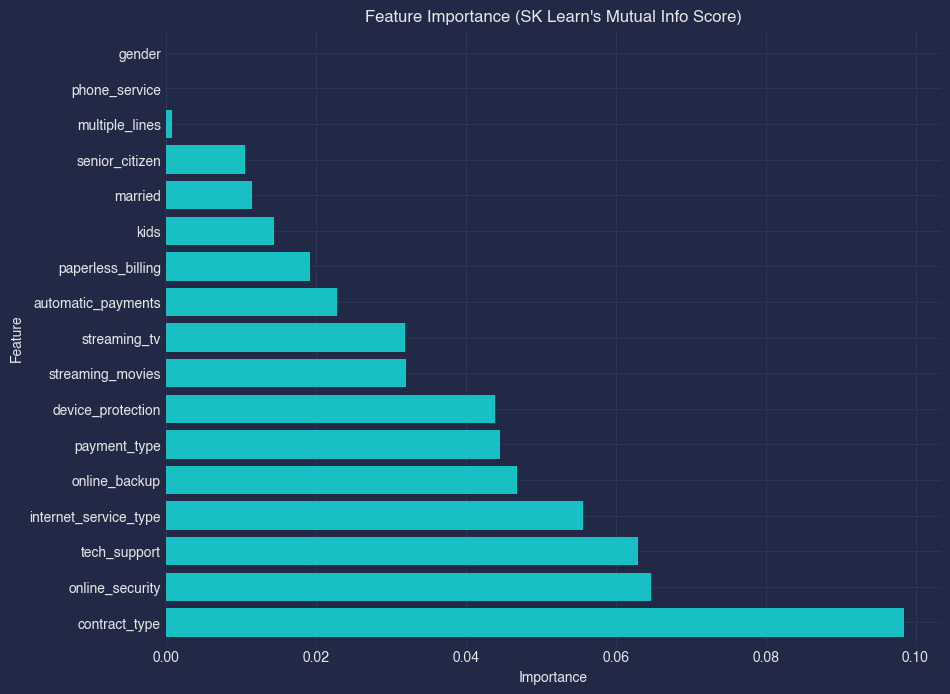

In [16]:
from sklearn.metrics import mutual_info_score

def compute_mutual_information(categorical_series):
    return mutual_info_score(categorical_series, df_telco['churn'])

# select categorial variables excluding the response variable 
categorical_variables = df_telco.select_dtypes(include=object).drop('churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

feature_importance.sort_values(ascending=False)
ax = feature_importance.plot(kind='barh', figsize=(10,8), zorder=2, width=0.8)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title("Feature Importance (SK Learn's Mutual Info Score)")
plt.show()

In [17]:
# To avoid uneccessary columns and reduce potential overfitting, we'll drop columns that seem to have no affect on churning

train.drop(columns=['gender', 'phone_service', 'multiple_lines'], inplace=True)

validate.drop(columns=['gender', 'phone_service', 'multiple_lines'], inplace=True)

test.drop(columns=['gender', 'phone_service', 'multiple_lines'], inplace=True)

## Make Binary, Features, & Splits (Preprocessing)

### Binary

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def telco_binary_normalized(df):
        '''
        This function takes in a dataframe and returns a modified dataframe with binary values for certain columns and one-hot encoded values for categorical columns.
        
        Parameters:
        -----------
        df : pandas dataframe
                The dataframe to be modified.
        
        Returns:
        --------
        df : pandas dataframe
                The modified dataframe with binary values for certain columns and one-hot encoded values for categorical columns.
        '''
        df.replace({
                        'No internet service': 0,
                        'No phone service': 0,
                        'No': 0,
                        'Yes': 1,
                        'Male': 1, 
                        'Female': 0}, inplace=True)
                
        # 3 Categories (but we want to keep all 3, rather than keeping the original column)
        categorical = ['contract_type', 'payment_type', 'internet_service_type']

        cat = pd.get_dummies(df[categorical], drop_first=False, dtype='int')

        # Rename for uniformity
        cat.rename(columns={'contract_type_Month-to-month':'month_to_month_contract',
                                                'contract_type_One year':'one_year_contract',
                                                'contract_type_Two year':'two_year_contact',
                                                'payment_type_bank transfer':'bank_transfer_payment',
                                                'payment_type_credit card':'credit_card_payment', 
                                                'payment_type_electronic check':'e_check_payment',
                                                'payment_type_mailed check':'mailed_check_payment',
                                                'internet_service_type_DSL':'dsl_internet',
                                                'internet_service_type_Fiber optic':'fiber_optic_internet'}
                        , inplace=True)

        df = pd.concat([df, cat], axis=1)
        
        # Drop columns that are now redundant after get_dummies
        df.drop(columns=['internet_service_type_0', 'contract_type', 'internet_service_type', 'payment_type'], inplace=True)
        
        '''
        # min-max normalization (numeric variables)
        normalize_columns = ['tenure_months', 'monthly_charges', 'total_charges', 'total_add_ons', 'tenure_years']

        # scale numerical variables using min max scaler
        for column in normalize_columns:
                # minimum value of the column
                min_column = df[column].min()
                # maximum value of the column
                max_column = df[column].max()
                # min max scaler
                df[column] = (df[column] - min_column) / (max_column - min_column)
        '''
        # Scale the non-binary numerical columns for normalization in the ML models
        
        # create a MinMaxScaler object
        scaler = MinMaxScaler()

        # select the columns to scale
        cols_to_scale = ['tenure_months', 'monthly_charges', 'total_charges', 'total_add_ons', 'tenure_years']

        # fit the scaler to the selected columns
        scaler.fit(df[cols_to_scale])

        # transform the selected columns
        df[cols_to_scale] = scaler.transform(df[cols_to_scale])
        return df


### Establish Baseline

In [19]:
# Models need to outperform the baseline (73% to be considered for future predictions)

print(f'Baseline: {round(train["churn"].value_counts(normalize=True), 2)[0] * 100}%')

Baseline: 73.0%


### X, Y Splits

In [20]:
# Convert the 3 splits into binary and normalized data

train = telco_binary_normalized(train)
validate = telco_binary_normalized(validate)
test = telco_binary_normalized(test)

In [21]:
train.dtypes

senior_citizen               int64
married                      int64
kids                         int64
tenure_months              float64
online_security              int64
online_backup                int64
device_protection            int64
tech_support                 int64
streaming_tv                 int64
streaming_movies             int64
paperless_billing            int64
monthly_charges            float64
total_charges              float64
churn                        int64
automatic_payments           int64
tenure_years               float64
total_add_ons              float64
month_to_month_contract      int64
one_year_contract            int64
two_year_contact             int64
bank_transfer_payment        int64
credit_card_payment          int64
e_check_payment              int64
mailed_check_payment         int64
dsl_internet                 int64
fiber_optic_internet         int64
dtype: object

In [22]:
# # Define features based on exploration.

# # Most important
# features1 = ['total_charges',
#             'monthly_charges',
#             'month_to_month_contract',
#             'tenure_months',
#             'tenure_years',
#             'two_year_contact',
#             'fiber_optic_internet']

# # Important (Inclusive of higher features)
# features2 = (features1 + [
#             'e_check_payment',
#             'automatic_payments',
#             'total_add_ons',
#             'one_year_contract',
#             'paperless_billing',
#             'kids',
#             'online_security',
#             'married',
#             'tech_support',
#             'bank_transfer_payment',
#             'senior_citizen'])

# # Least important (Inclusive of higher features)
# features3 = (features2 + [
#             'dsl_internet',
#             'online_backup',
#             'mailed_check_payment',
#             'device_protection',
#             'streaming_movies',
#             'streaming_tv'])

features = ['monthly_charges',
            'paperless_billing',
            'e_check_payment',
            'fiber_optic_internet',
            'tech_support',
            'senior_citizen',
            'month_to_month_contract',
            'tenure_years',
            'total_charges',
            'monthly_charges',
            'device_protection']

In [23]:
# Create X & y version of train, validate, test where y is a series with just the target variable and X are all the features. 

# We'll do exploration and train our model on the train data
X_train = train.drop(columns=['churn'])
y_train = train['churn']

# We tune our model on validate, since it will be out-of-sample until we use it. 
X_validate = validate.drop(columns=['churn'])
y_validate = validate['churn']

# Keep the test separate, for our final out-of-sample dataset, to see how well our tuned model performs on new data.
X_test = test.drop(columns=['churn'])
y_test = test['churn']

## Build Models

### K-Nearest Neighbor

In [24]:
start_time = time.time()

from sklearn.neighbors import KNeighborsClassifier

knnmetrics = []
features = features

for k in range(1, 20):
    # KNN
    # model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train[features], y_train)
    # Accuracies
    ytr_acc = knn.score(X_train[features], y_train).round(10)
    yv_acc = knn.score(X_validate[features], y_validate).round(10)
    # Make it into a DF
    output = {
        'model': knn,
        'features': features,
        'train_acc': ytr_acc,
        'validate_acc': yv_acc
    }
    knnmetrics.append(output)
     
end_time = time.time()
print("Execution time:", round(end_time - start_time, 2), "seconds")

Execution time: 2.79 seconds


In [25]:
knn = pd.DataFrame(knnmetrics)
knn['difference_score'] = abs(knn.train_acc - knn.validate_acc).round(10)
knn['avg_score'] = ((knn.train_acc + knn.validate_acc)/2).round(10)

# Top 3
top_3 = knn.sort_values(['validate_acc', 'difference_score'], ascending=[False, True]).head(3)
print("Top 3:")
print(top_3)

# Bottom 3
bottom_3 = knn.sort_values(['validate_acc', 'difference_score'], ascending=[True, True]).head(3)
print("Bottom 3:")
print(bottom_3)


Top 3:
                                   model  \
13  KNeighborsClassifier(n_neighbors=14)   
12  KNeighborsClassifier(n_neighbors=13)   
14  KNeighborsClassifier(n_neighbors=15)   

                                                                                                                                                                                               features  \
13  [monthly_charges, paperless_billing, e_check_payment, fiber_optic_internet, tech_support, senior_citizen, month_to_month_contract, tenure_years, total_charges, monthly_charges, device_protection]   
12  [monthly_charges, paperless_billing, e_check_payment, fiber_optic_internet, tech_support, senior_citizen, month_to_month_contract, tenure_years, total_charges, monthly_charges, device_protection]   
14  [monthly_charges, paperless_billing, e_check_payment, fiber_optic_internet, tech_support, senior_citizen, month_to_month_contract, tenure_years, total_charges, monthly_charges, device_protection]   

   

In [26]:
knn.iloc[13]

model                                                                                                                                                                              KNeighborsClassifier(n_neighbors=14)
features            [monthly_charges, paperless_billing, e_check_payment, fiber_optic_internet, tech_support, senior_citizen, month_to_month_contract, tenure_years, total_charges, monthly_charges, device_protection]
train_acc                                                                                                                                                                                                       0.80421
validate_acc                                                                                                                                                                                                   0.791839
difference_score                                                                                                                        

### Predictions

In [27]:
features = knn['features'].iloc[17]

best_knn = knn['model'].iloc[17]

best_knn.fit(X_train[features], y_train)

y_pred = best_knn.predict(X_train[features])

y_pred_proba = best_knn.predict_proba(X_train[features])

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2897
           1       0.68      0.47      0.55      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.69      0.71      3943
weighted avg       0.79      0.80      0.79      3943



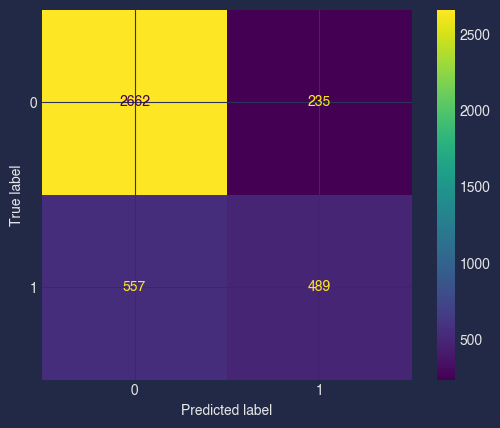

In [28]:
print(classification_report(y_train, y_pred))

knncm = confusion_matrix(y_train, y_pred)

knndisp = ConfusionMatrixDisplay(knncm)

knndisp.plot()
plt.show()

In [29]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
all = tn + fp + fn + tp

print('KNN Report')
print('------------------------')

accuracy = (tp + tn)/all
print(f"Accuracy: {accuracy}")

true_positive_rate = tp/(tp+fn)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = fp/(fp+tn)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = tn/(tn+fp)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = fn/(fn+tp)
print(f"False Negative Rate: {false_negative_rate}")

precision = tp/(tp+fp)
print(f"Precision: {precision}")

recall = tp/(tp+fn)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = tp + fn
print(f"Support (0): {support_pos}")

support_neg = fp + tn
print(f"Support (1): {support_neg}")

KNN Report
------------------------
Accuracy: 0.7991377124017246
True Positive Rate: 0.46749521988527726
False Positive Rate: 0.08111839834311356
True Negative Rate: 0.9188816016568865
False Negative Rate: 0.5325047801147228
Precision: 0.675414364640884
Recall: 0.46749521988527726
F1 Score: 0.552542372881356
Support (0): 1046
Support (1): 2897


#### Decision Tree Classifier

In [31]:
start_time = time.time()

from sklearn.tree import DecisionTreeClassifier

# Only ran on features1 (deemed most important), with more time, more iterations could be ran

import itertools

dtcmetrics = []
for r in range(2,(len(features)+1)):
    for feature,d in itertools.product(itertools.combinations(features,r),range(1,3)):
        f = list(feature)
        # decision tree
        # model
        tree = DecisionTreeClassifier(max_depth=d,random_state=123)
        tree = tree.fit(X_train[f],y_train)
        # accuracies
        dtc_train_acc = (tree.score(X_train[f],y_train)).round(10)
        dtc_val_acc = (tree.score(X_validate[f],y_validate)).round(10)
        # Make it into a DF
        output = {
            'model':tree,
            'features':f,
            'train_acc':dtc_train_acc,
            'validate_acc':dtc_val_acc
        }
        dtcmetrics.append(output)
        
end_time = time.time()
print("Execution time:", round(end_time - start_time, 2), "seconds")

Execution time: 11.17 seconds


In [32]:
dtc = pd.DataFrame(dtcmetrics)
dtc['difference_score'] = abs(dtc.train_acc - dtc.validate_acc).round(10)
dtc['avg_score'] = ((dtc.train_acc + dtc.validate_acc)/2).round(10)
dtc.sort_values(['validate_acc', 'difference_score'], ascending=[False, True]).head(3)

,model,features,train_acc,validate_acc,difference_score,avg_score
63,"DecisionTreeClassifier(max_depth=2, random_state=123)","[fiber_optic_internet, total_charges]",0.788232,0.792431,0.004198,0.790331
153,"DecisionTreeClassifier(max_depth=2, random_state=123)","[monthly_charges, fiber_optic_internet, total_charges]",0.788232,0.792431,0.004198,0.790331
225,"DecisionTreeClassifier(max_depth=2, random_state=123)","[paperless_billing, fiber_optic_internet, total_charges]",0.788232,0.792431,0.004198,0.790331


In [33]:
dtc.iloc[253]

model                    DecisionTreeClassifier(max_depth=2, random_state=123)
features            [paperless_billing, month_to_month_contract, tenure_years]
train_acc                                                             0.742075
validate_acc                                                          0.743938
difference_score                                                      0.001864
avg_score                                                             0.743007
Name: 253, dtype: object

### Predictions

In [34]:
features = dtc['features'].iloc[253]

best_dtc = dtc['model'].iloc[253]

best_dtc.fit(X_train[features], y_train)

y_pred = best_dtc.predict(X_train[features])

y_pred_proba = best_dtc.predict_proba(X_train[features])

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2897
           1       0.70      0.63      0.66      1046

    accuracy                           0.83      3943
   macro avg       0.79      0.77      0.77      3943
weighted avg       0.83      0.83      0.83      3943

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2897
           1       0.70      0.63      0.66      1046

    accuracy                           0.83      3943
   macro avg       0.79      0.77      0.77      3943
weighted avg       0.83      0.83      0.83      3943



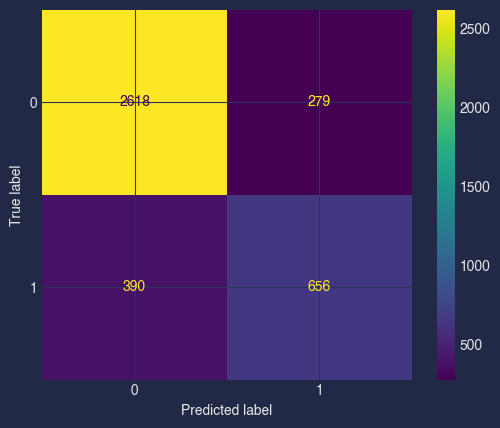

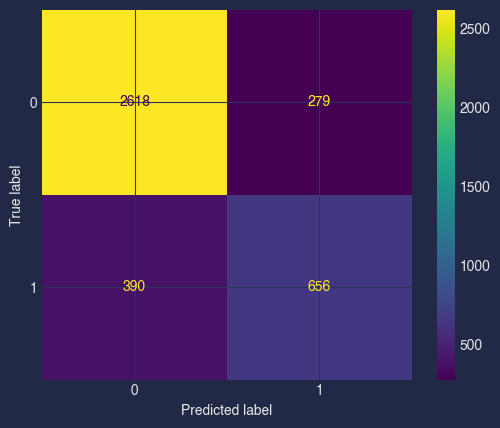

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)

print(classification_report(y_train, y_pred))

cm = confusion_matrix(y_train, y_pred)

dtcdisp = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)

dtcdisp.plot()
print(classification_report(y_train, y_pred))

cm = confusion_matrix(y_train, y_pred)

dtcdisp = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)

dtcdisp.plot()


In [37]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
all = tn + fp + fn + tp

print('DTC Report')
print('------------------------')

accuracy = (tp + tn)/all
print(f"Accuracy: {accuracy}")

true_positive_rate = tp/(tp+fn)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = fp/(fp+tn)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = tn/(tn+fp)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = fn/(fn+tp)
print(f"False Negative Rate: {false_negative_rate}")

precision = tp/(tp+fp)
print(f"Precision: {precision}")

recall = tp/(tp+fn)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = tp + fn
print(f"Support (0): {support_pos}")

support_neg = fp + tn
print(f"Support (1): {support_neg}")

DTC Report
------------------------
Accuracy: 0.8303322343393356
True Positive Rate: 0.627151051625239
False Positive Rate: 0.09630652399033483
True Negative Rate: 0.9036934760096652
False Negative Rate: 0.372848948374761
Precision: 0.7016042780748664
Recall: 0.627151051625239
F1 Score: 0.662291771832408
Support (0): 1046
Support (1): 2897


#### Random Forest

In [38]:
import itertools
import time
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

rfcmetrics = []

# Define the range of values for r and d (added due to very length run times)
min_r = 2
max_r = 3
max_d = 5

for r in range(min_r, min(max_r, len(features)) + 1):
    for feature, d in itertools.product(itertools.combinations(features, r), range(1, min(max_d, 11))):
        f = list(feature)
        # random forest
        forest = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=123)
        forest = forest.fit(X_train[f], y_train)
        # accuracies
        rfc_train_acc = (forest.score(X_train[f], y_train)).round(10)
        rfc_val_acc = (forest.score(X_validate[f], y_validate)).round(10)
        # Make it into a DF
        output = {
            'model': forest,
            'features': f,
            'train_acc': rfc_train_acc,
            'validate_acc': rfc_val_acc
        }
        rfcmetrics.append(output)

end_time = time.time()
print("Execution time:", round(end_time - start_time, 2), "seconds")
# 20~ seconds

Execution time: 1.28 seconds


In [40]:
# Make results into DataFrame
# Random Tree model outputs every Decision Tree created within the random tree, not a pretty output, we can still utilize 'features'.

pd.set_option('display.max_colwidth', 1000)

rfc = pd.DataFrame(rfcmetrics)
rfc['difference_score'] = abs(rfc.train_acc - rfc.validate_acc).round(10)
rfc['avg_score'] = ((rfc.train_acc + rfc.validate_acc)/2).round(10)
rfc.sort_values(['validate_acc', 'difference_score'], ascending=[False, True]).head(3)

,model,features,train_acc,validate_acc,difference_score,avg_score
13,"(DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=843828734), DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=914636141), DecisionTreeClassifier(max_depth=2, max_features='sqrt',\n random_state=1228959102), DecisionTreeClassifier(max_depth=2, max_features='sqrt',\n random_state=1840268610), DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=974319580), DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=819844194), DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=220395238), DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=941243409), DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=942612051), DecisionTreeClassifier(max_depth=2, max_features='sqrt',\n random_state=2109339754), DecisionTreeClassifier(max_depth=2, max_features='sqrt',\n random_state=181722...","[paperless_billing, month_to_month_contract, tenure_years]",0.766168,0.772915,0.006748,0.769542
14,"(DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=843828734), DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=914636141), DecisionTreeClassifier(max_depth=3, max_features='sqrt',\n random_state=1228959102), DecisionTreeClassifier(max_depth=3, max_features='sqrt',\n random_state=1840268610), DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=974319580), DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=819844194), DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=220395238), DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=941243409), DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=942612051), DecisionTreeClassifier(max_depth=3, max_features='sqrt',\n random_state=2109339754), DecisionTreeClassifier(max_depth=3, max_features='sqrt',\n random_state=181722...","[paperless_billing, month_to_month_contract, tenure_years]",0.766168,0.772915,0.006748,0.769542
15,"(DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=843828734), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=914636141), DecisionTreeClassifier(max_depth=4, max_features='sqrt',\n random_state=1228959102), DecisionTreeClassifier(max_depth=4, max_features='sqrt',\n random_state=1840268610), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=974319580), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=819844194), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=220395238), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=941243409), DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=942612051), DecisionTreeClassifier(max_depth=4, max_features='sqrt',\n random_state=2109339754), DecisionTreeClassifier(max_depth=4, max_features='sqrt',\n random_state=181722...","[paperless_billing, month_to_month_contract, tenure_years]",0.766168,0.772915,0.006748,0.769542


### Predictions

In [43]:
pd.set_option('display.max_colwidth', 100)
rfc.iloc[13]

model               (DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=843828734), DecisionTreeC...
features                                                     [paperless_billing, month_to_month_contract, tenure_years]
train_acc                                                                                                      0.766168
validate_acc                                                                                                   0.772915
difference_score                                                                                               0.006748
avg_score                                                                                                      0.769542
Name: 13, dtype: object

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2897
           1       0.70      0.63      0.66      1046

    accuracy                           0.83      3943
   macro avg       0.79      0.77      0.77      3943
weighted avg       0.83      0.83      0.83      3943



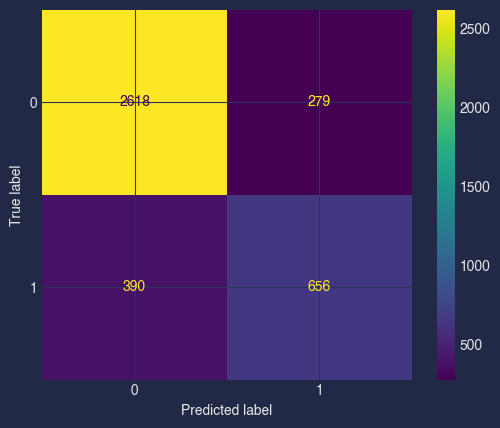

In [48]:
print(classification_report(y_train, y_pred))

rfccm = confusion_matrix(y_train, y_pred)

rfcdisp = ConfusionMatrixDisplay(rfccm)

rfcdisp.plot()
plt.show()

In [50]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
all = tn + fp + fn + tp

print('RFC Report')
print('------------------------')

accuracy = (tp + tn)/all
print(f"Accuracy: {accuracy}")

true_positive_rate = tp/(tp+fn)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = fp/(fp+tn)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = tn/(tn+fp)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = fn/(fn+tp)
print(f"False Negative Rate: {false_negative_rate}")

precision = tp/(tp+fp)
print(f"Precision: {precision}")

recall = tp/(tp+fn)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = tp + fn
print(f"Support (0): {support_pos}")

support_neg = fp + tn
print(f"Support (1): {support_neg}")

RFC Report
------------------------
Accuracy: 0.8303322343393356
True Positive Rate: 0.627151051625239
False Positive Rate: 0.09630652399033483
True Negative Rate: 0.9036934760096652
False Negative Rate: 0.372848948374761
Precision: 0.7016042780748664
Recall: 0.627151051625239
F1 Score: 0.662291771832408
Support (0): 1046
Support (1): 2897


### Logistic Regression

In [51]:
start_time = time.time()

from sklearn.linear_model import LogisticRegression

lrmetrics = []
features = features

for r, c, p in itertools.product(range(2, len(features)+1), [0.01, 0.1, 1, 10, 100], ['l2', None]):
    # logistic regression
    # model
    lr = LogisticRegression(C=c, random_state=123, penalty=p)
    lr.fit(X_train[features], y_train)
    # accuracies
    ytr_acc = lr.score(X_train[features], y_train).round(10)
    yv_acc = lr.score(X_validate[features], y_validate).round(10)
    # Make it into a DF
    output = {
        'model': lr,
        'features': features,
        'train_acc': ytr_acc,
        'validate_acc': yv_acc
    }
    lrmetrics.append(output)
    
end_time = time.time()
print("Execution time:", round(end_time - start_time, 2), "seconds")

Execution time: 0.5 seconds


In [52]:
pd.set_option('display.max_colwidth', 500)
lr = pd.DataFrame(lrmetrics)
lr['difference_score'] = abs(lr.train_acc - lr.validate_acc).round(10)
lr['avg_score'] = ((lr.train_acc + lr.validate_acc)/2).round(10)
lr.sort_values(['validate_acc', 'difference_score'], ascending=[False, True]).head(3)

,model,features,train_acc,validate_acc,difference_score,avg_score
1,"LogisticRegression(C=0.01, penalty=None, random_state=123)","[paperless_billing, month_to_month_contract, tenure_years]",0.766168,0.772915,0.006748,0.769542
2,"LogisticRegression(C=0.1, random_state=123)","[paperless_billing, month_to_month_contract, tenure_years]",0.766168,0.772915,0.006748,0.769542
3,"LogisticRegression(C=0.1, penalty=None, random_state=123)","[paperless_billing, month_to_month_contract, tenure_years]",0.766168,0.772915,0.006748,0.769542


In [53]:
lr.iloc[2]

model                              LogisticRegression(C=0.1, random_state=123)
features            [paperless_billing, month_to_month_contract, tenure_years]
train_acc                                                             0.766168
validate_acc                                                          0.772915
difference_score                                                      0.006748
avg_score                                                             0.769542
Name: 2, dtype: object

### Predictions

In [54]:
best_lr = lr['model'].iloc[2]

best_lr.fit(X_train[features], y_train)

y_pred = best_lr.predict(X_train[features])

y_pred_proba = best_lr.predict_proba(X_train[features])

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2897
           1       0.59      0.39      0.47      1046

    accuracy                           0.77      3943
   macro avg       0.70      0.64      0.66      3943
weighted avg       0.75      0.77      0.75      3943



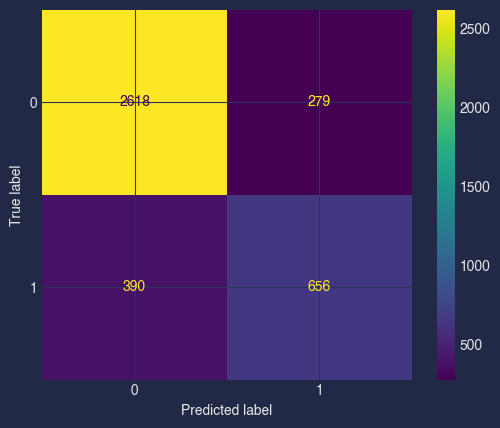

In [55]:
print(classification_report(y_train, y_pred))

lrcm = confusion_matrix(y_train, y_pred)

# Use the first element of best_dtc_features instead of the whole list
lrdisp = ConfusionMatrixDisplay(cm)

lrdisp.plot()
plt.show()

In [56]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
all = tn + fp + fn + tp

print('LR Report')
print('------------------------')

accuracy = (tp + tn)/all
print(f"Accuracy: {accuracy}")

true_positive_rate = tp/(tp+fn)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = fp/(fp+tn)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = tn/(tn+fp)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = fn/(fn+tp)
print(f"False Negative Rate: {false_negative_rate}")

precision = tp/(tp+fp)
print(f"Precision: {precision}")

recall = tp/(tp+fn)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = tp + fn
print(f"Support (0): {support_pos}")

support_neg = fp + tn
print(f"Support (1): {support_neg}")

LR Report
------------------------
Accuracy: 0.7661678924676643
True Positive Rate: 0.3862332695984704
False Positive Rate: 0.09665170866413532
True Negative Rate: 0.9033482913358647
False Negative Rate: 0.6137667304015296
Precision: 0.5906432748538012
Recall: 0.3862332695984704
F1 Score: 0.46705202312138727
Support (0): 1046
Support (1): 2897


## Model Evaluation

In [62]:
def scores_plotted(data, name=None):
    df = data.sort_values(['validate_acc', 'train_acc'], ascending=[False, True]).head(10).reset_index()
    # plot
    plt.figure(figsize=(8, 5))
    plt.plot(df.index, df.train_acc, label='Train', marker='o')
    plt.plot(df.index, df.validate_acc, label='Validate', marker='o')
    plt.fill_between(df.index, df.train_acc, df.validate_acc, alpha=0.2)
    # plt.plot(df.index, df.avg_score, label='Average', marker='o')
    plt.xlabel('Model Number as Index in DF', fontsize=10)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title(f'Classification Model Performance: {name}', fontsize=18)
    plt.legend(title='Scores', fontsize=12)
    plt.show()
    pd.set_option('display.max_colwidth', None)
    print(f'Total Models Ran: {len(data)}')
    print('--------------------------------')
    print(f'Best {name} Hyperparameters:')
    print(data.sort_values(['validate_acc', 'train_acc'], ascending=[False, True]).iloc[0]['model'])
    print('--------------------------------')
    print(f'Best {name} Features:')
    print(data.sort_values(['validate_acc', 'train_acc'], ascending=[False, True]).iloc[0]['features'])
    print('--------------------------------')
    print(f'Best {name} Average Accuracy:')
    print(data.sort_values(['validate_acc', 'train_acc'], ascending=[False, True]).iloc[0]['avg_score'])
    return df

The best average score out of all of the models was KNeighbors:
- K: 18
- Features: [total_charges, monthly_charges, month_to_month_contract, tenure_months, tenure_years, two_year_contact, fiber_optic_internet]

In [66]:
best_knn.fit(X_train[features], y_train)

KNeighborsClassifier(n_neighbors=18)

## Validate

Accuracy of KNN Classifier on test set: 0.734


<function matplotlib.pyplot.show(close=None, block=None)>

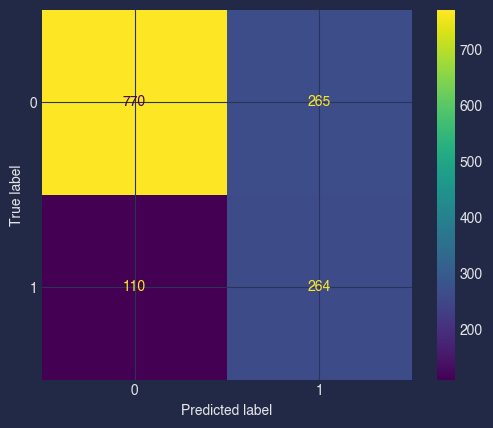

In [67]:
print(f'Accuracy of KNN Classifier on test set: {round(best_knn.score(X_test[features], y_test),3)}')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predict labels of test set
y_pred = best_knn.predict(X_test[features])

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show

In [ ]:
telcoknn = telco_binary_normalized(df_telco)

In [ ]:
features = ['total_charges', 'monthly_charges', 'month_to_month_contract', 'tenure_months', 'tenure_years', 'two_year_contact', 'fiber_optic_internet']

best_knn = KNeighborsClassifier(n_neighbors=18)

best_knn.fit(telcoknn[features], telcoknn['churn'])

y_pred = best_knn.predict(telcoknn[features])

y_pred_proba = best_knn.predict_proba(telcoknn[features])

In [ ]:
# Due to already high false positives, we will make = 0.5 won't churn

df = pd.DataFrame(y_pred_proba, columns=['prediction_of_churn', 'probability_of_churn'])
df['prediction_of_churn'] = df['prediction_of_churn'].apply(lambda x: 0 if x >= 0.5 else 1)
df = df[['probability_of_churn', 'prediction_of_churn']]
df

,probability_of_churn,prediction_of_churn
0,0.166667,0
1,0.111111,0
2,0.666667,1
3,0.666667,1
4,0.500000,0
...,...,...
7038,0.055556,0
7039,0.277778,0
7040,0.555556,1
7041,0.000000,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   probability_of_churn  7043 non-null   float64
 1   prediction_of_churn   7043 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 110.2 KB


In [ ]:
df_telco.shape

(7043, 23)

In [ ]:
df_telco.reset_index(inplace=True)
df_telco.rename(columns={'index': 'customer_id'}, inplace=True)

In [ ]:
telco_with_predictions = pd.concat([df_telco, df], axis=1)

In [ ]:
predictions = telco_with_predictions.drop(columns=[
    # 'customer_id',
    'gender', 
    'senior_citizen',
    'married',
    'kids',
    'tenure_months', 
    'phone_service', 
    'multiple_lines', 
    'online_security',
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_tv',
    'streaming_movies', 
    'paperless_billing', 
    'monthly_charges',
    'total_charges', 
    'churn', 
    'contract_type', 
    'internet_service_type',
    'payment_type', 
    'automatic_payments', 
    'tenure_years', 
    'total_add_ons',
    # 'probability_of_churn', 
    # 'prediction_of_churn'
])
